# CNNs in Pytorch - Practice Using the Kuzushiji-MNIST Dataset Available in Torchvision

https://pytorch.org/vision/0.8/datasets.html#kmnist

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchmetrics
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import japanize_matplotlib # to display Japanese text in matplotlib

## Loading the Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

kmnist_train = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
kmist_test = datasets.KMNIST(root='./data', train=False, transform=transform)

In [4]:
dataloader_train = torch.utils.data.DataLoader(kmnist_train, batch_size=2, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(kmist_test, batch_size=2, shuffle=False)

In [5]:
hiragana = {0:'お', 1:'き', 2:'す', 3:'つ', 4:'な', 5:'は', 6:'ま', 7:'や', 8:'れ', 9:'を'}

In [6]:
num_classes = len(kmnist_train.classes)
kmnist_train.classes

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

torch.Size([2, 1, 28, 28])


Text(0.5, 0.98, 'Training Image Sample')

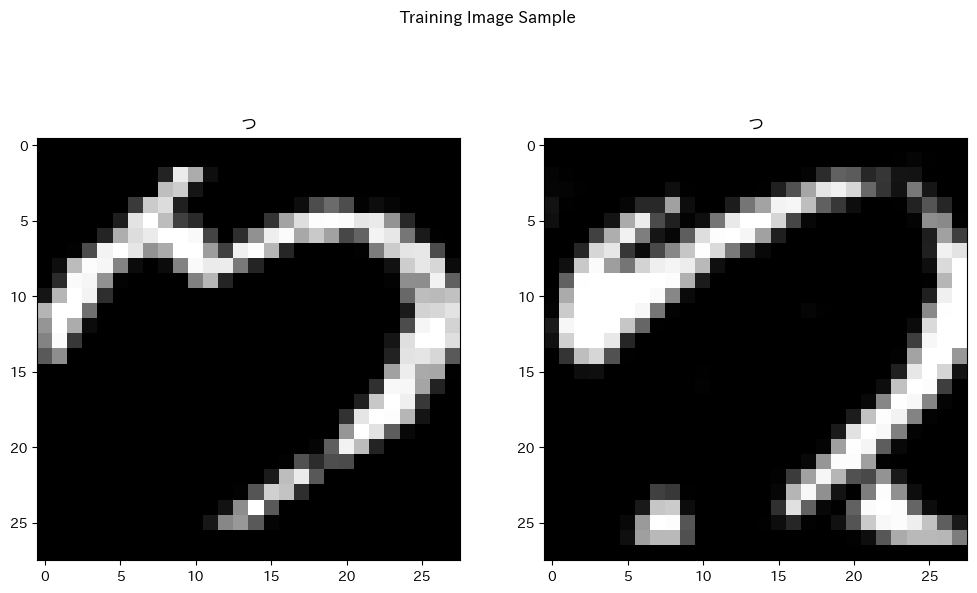

In [14]:
images, labels = next(iter(dataloader_train))
print(images.shape)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 7))
axes[0].imshow(images[0].squeeze(), cmap='gray')
axes[0].title.set_text(hiragana[labels[0].item()])
axes[1].imshow(images[1].squeeze(), cmap='gray')
axes[1].title.set_text(hiragana[labels[1].item()])
plt.suptitle('Training Image Sample')

## Defining the Model

In [30]:
# Checking input and layer output shapes.
# output shape = (((width - kernel_size) + 2*padding)/stride) + 1
images, labels = next(iter(dataloader_train))
conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=1)
pool = torch.nn.MaxPool2d(2,2)
conv2 = torch.nn.Conv2d(32, 54, kernel_size=3, padding=1)
print(images.shape)
x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)

torch.Size([2, 1, 28, 28])
torch.Size([2, 32, 28, 28])
torch.Size([2, 32, 14, 14])
torch.Size([2, 54, 14, 14])
torch.Size([2, 54, 7, 7])


In [56]:
class Net(torch.nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3,padding=1)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv2 = torch.nn.Conv2d(32, 54, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(54*7*7, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(-1, 54*7*7) # Flatten input tensor
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.relu(x)
        x = self.fc3(x)
        return x

In [57]:
model = Net(num_classes=num_classes).to(device)

In [58]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [59]:
n_total_steps = len(dataloader_train)
n_total_steps

30000

In [60]:
num_epochs = 4

In [61]:
epoch_losses = []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(dataloader_train):
        # origin shape [2, 1, 28, 28]
        # input_layer: 1 input channel, 32 output channels, 3 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 ==0:
            print(f'Epoch: [{epoch+1}/{num_epochs}], Step: [{i+1}/{n_total_steps}], Loss: [{loss.item()}]')
    epoch_losses.append(running_loss/n_total_steps)

Epoch: [1/4], Step: [2000/30000], Loss: [0.08078722655773163]
Epoch: [1/4], Step: [4000/30000], Loss: [0.184141606092453]
Epoch: [1/4], Step: [6000/30000], Loss: [0.5267646908760071]
Epoch: [1/4], Step: [8000/30000], Loss: [0.0007692135404795408]
Epoch: [1/4], Step: [10000/30000], Loss: [8.940688758229953e-07]
Epoch: [1/4], Step: [12000/30000], Loss: [9.71546342043439e-06]
Epoch: [1/4], Step: [14000/30000], Loss: [1.591421096236445e-05]
Epoch: [1/4], Step: [16000/30000], Loss: [0.001451314426958561]
Epoch: [1/4], Step: [18000/30000], Loss: [0.6591463088989258]
Epoch: [1/4], Step: [20000/30000], Loss: [0.18014222383499146]
Epoch: [1/4], Step: [22000/30000], Loss: [0.0006658319616690278]
Epoch: [1/4], Step: [24000/30000], Loss: [0.0002105404855683446]
Epoch: [1/4], Step: [26000/30000], Loss: [4.470336079975823e-06]
Epoch: [1/4], Step: [28000/30000], Loss: [6.55650637781946e-07]
Epoch: [1/4], Step: [30000/30000], Loss: [3.7731220722198486]
Epoch: [2/4], Step: [2000/30000], Loss: [0.000496

Text(0.5, 1.0, 'Training Loss Over 4 Epochs')

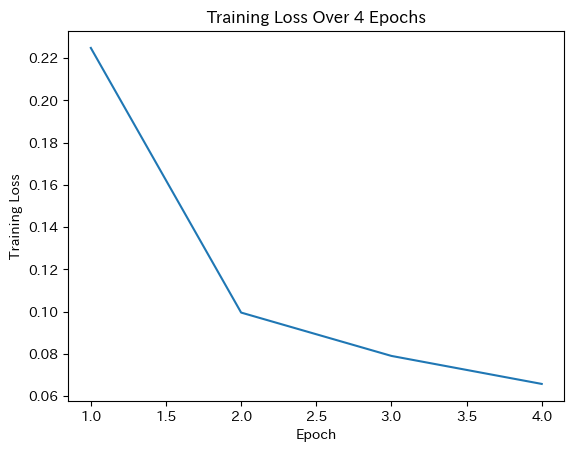

In [72]:
training_losses = pd.DataFrame(epoch_losses, columns=['Loss'],index=list(range(1,5)))
training_losses
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over 4 Epochs')

## Evaluating the Model

In [98]:
evaluation_criteria = torchmetrics.Accuracy(task='multiclass', num_classes=10, average='macro')

In [102]:
model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model(images)
        evaluation_criteria.update(outputs, labels)
        #preds = outputs.argmax(dim=1)
#         print(labels)
#         print(preds)
#         evaluation_criteria(preds, labels.view(-1,1))
test_accuracy = evaluation_criteria.compute()
test_accuracy

tensor(0.9338)

### It looks like this model has a macro accuracy of around 93% across all 10 classes. Not bad!
Including a softmax() layer inside the CNN would have made model evaluation slightly simpler I feel.